In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numpy.linalg import svd
%matplotlib notebook
# %matplotlib inline
# %pylab inline

In [3]:
local = 1
if local:
    data=np.loadtxt('SK_demo3_features.txt',skiprows=1)
else:
    from google.colab import drive
    drive.mount('/content/drive')

    root = '/content/drive/My Drive'
    data_path = os.path.join(root,'PMTs/')

    data=np.loadtxt(data_path+'SK_demo3_features.txt',skiprows=1)
# FeatureID: Column 1
# RecoWorldPosition: Columns 28-30
# Note: repalced "-" to tab, to parse data

In [4]:
print (data.shape)
print (np.unique(data.T[0]))
print (np.unique(data.T[1]))

(599, 64)
[451. 452. 453. 502. 503. 504. 553. 554. 555. 604. 605. 606. 655. 656.
 657. 706. 707. 708. 757. 758. 759. 808. 809. 810.]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24.]


In [5]:
PMTs = np.unique(data.T[0])
IDs, bolts, x, y, z = [data.T[i] for i in (0, 1, 28, 29, 30)]

<IPython.core.display.Javascript object>


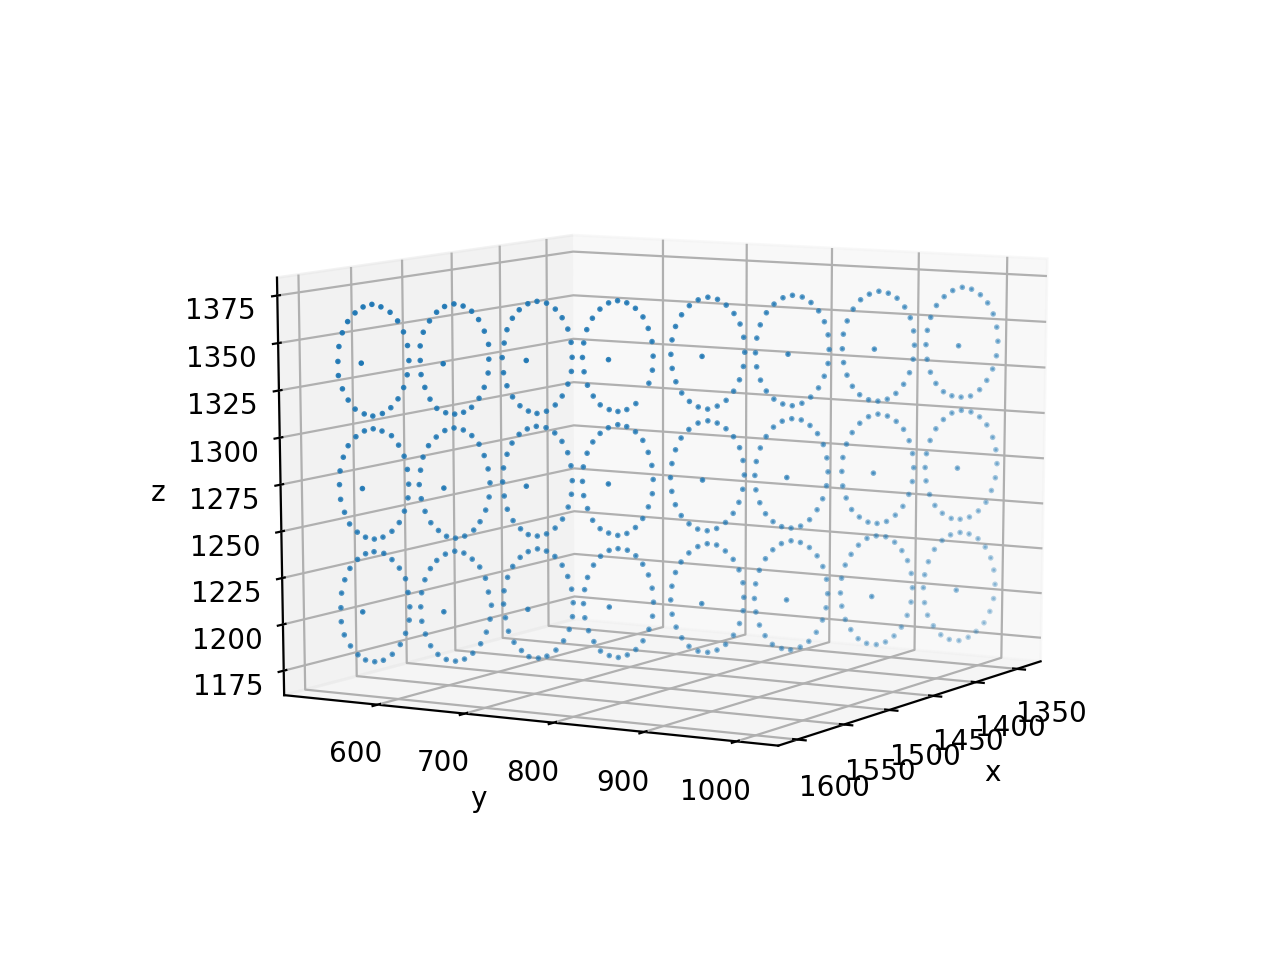

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, s=1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(10, 30)
show()

In [7]:
## https://stackoverflow.com/questions/12299540/plane-fitting-to-4-or-more-xyz-points
def fit_plane(points):
    """
    p, n = planeFit(points)

    Given an array, points, of shape (d,...)
    representing points in d-dimensional space,
    fit an d-dimensional plane to the points.
    Return a point, p, on the plane (the point-cloud centroid),
    and the normal, n.
    """
    
    points = np.reshape(points, (np.shape(points)[0], -1)) # Collapse trialing dimensions
    assert points.shape[0] <= points.shape[1], "There are only {} points in {} dimensions.".format(points.shape[1], points.shape[0])
    ctr = points.mean(axis=1)
    x = points - ctr[:,np.newaxis]
    M = np.dot(x, x.T) # Could also use np.cov(x) here.
    return ctr, svd(M)[0][:,-1]

In [10]:
######### code test: pass
# PMT = PMTs[10]
# idx_test = np.where((IDs==PMT) & (bolts!=0))[0]
# points = data[idx_test][:,28:31]
# print (points.shape)
# p, n = fit_plane(points.T)
# print (p,n)

<IPython.core.display.Javascript object>


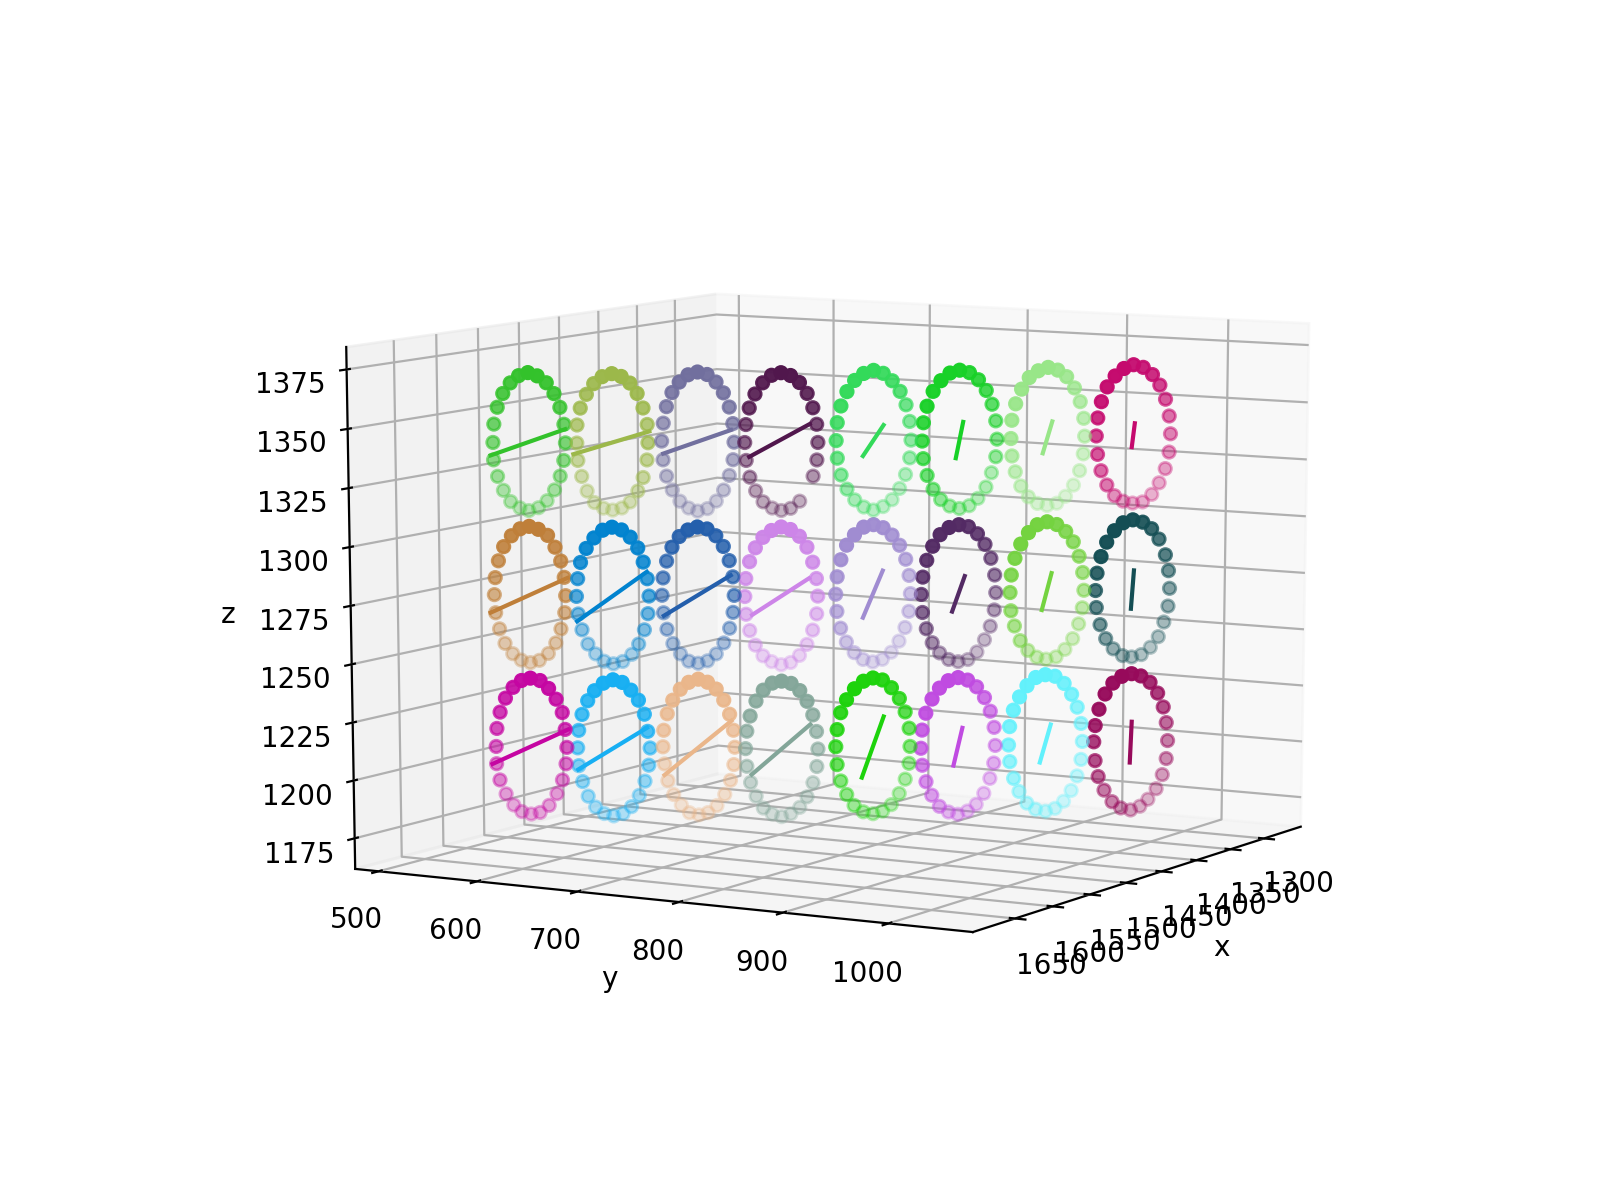

606.0 23


In [40]:
NN=100 ##### length of the normal direction to plot

plt.figure(figsize=(8,6))
ax = plt.subplot(111, projection='3d')

parr=[]
narr=[]
points_left = []
points_right = []
seed(10)
j=0
for PMT in PMTs:
    icolor=rand(3)
    idx_test = np.where((IDs==PMT) & (bolts!=0))[0]
    points = data[idx_test][:,28:31]
    
    p, n = fit_plane(points.T)
    
    if n[0]<0: ## make sure the unit vector is in the same direction
        n*=-1
    if len(points)<24:
        print (PMT, len(points))
    #### plot the PMT bolts
    xs, ys, zs = points.T
    ax.scatter(xs, ys, zs, color=icolor)

    #### plot the fitted normal direction
    X,Y,Z = [[p[i]-n[i]*NN, p[i]+n[i]*NN] for i in range(3)]
    ax.plot(X,Y,Z,color=icolor)
    
    narr.append(n)
    parr.append(p)
    if j<12:
        points_left.append(list(points))
    else:
        points_right.append(list(points))
    j+=1
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.view_init(10, 30)

points_left = concatenate(points_left,axis=0)
points_right = concatenate(points_right,axis=0)

In [48]:
####### calculate the mean normal angles
narr=np.array(narr)
parr=np.array(parr)

print (parr.shape, narr.shape, points_left.shape, points_right.shape)

###### mean normal direction of left 12 and right 12
N1 = mean(narr[:12],axis=0)
N2 = mean(narr[12:],axis=0)
print ('norm (avg of 12 angles)', N1, N2)

##### normal for fitting all 12 at once

N1_all = fit_plane(points_left.T)[1]
N2_all = -1*fit_plane(points_right.T)[1]
print ('norm (simultanous fit 12 PMTs)', N1_all, N2_all)
print ('diff (degrees)', np.degrees(np.arccos(np.dot(N1, N1_all))), np.degrees(np.arccos(np.dot(N1, N2_all))))

(24, 3) (24, 3) (287, 3) (288, 3)
norm (avg of 12 angles) [ 9.19205090e-01  3.93305815e-01 -1.16919203e-04] [ 0.83814349  0.54508259 -0.00368581]
norm (simultanous fit 12 PMTs) [0.92096727 0.38963011 0.00276839] [ 0.84481757  0.53504723 -0.00278088]
diff (degrees) 1.1423000119463513 9.249374148009672


In [135]:
out = concatenate( [PMTs.reshape(24,1), parr, narr],axis=1)
savetxt('PMTs_center_normal.txt', out)

In [59]:
cos1=np.dot(narr[:12], N1_all)
cos2=np.dot(narr[12:], N2_all)
theta1=np.degrees(np.arccos(cos1))
theta2=np.degrees(np.arccos(cos2))
diff_2walls = np.degrees(arccos(np.dot(N1_all, N2_all)))

# print (cos1)
# print (cos2)
print ('Angle between 2 walls (using normals fitted to 12 PMTs simultaneously):',diff_2walls)
print (theta1)
print (theta2)

Angle between 2 walls (using normals fitted to 12 PMTs simultaneously): 9.421031304763833
[1.02760083 0.55352465 0.44933129 0.44841578 1.70765578 1.35019962
 1.5087644  0.56977432 0.74392172 1.52423569 1.65276497 0.97194795]
[2.20304409 1.11900631 0.31851372 1.71672693 0.7504125  1.97960347
 0.77818133 0.52017556 0.55651656 1.52959815 1.23735833 1.51773956]


<IPython.core.display.Javascript object>


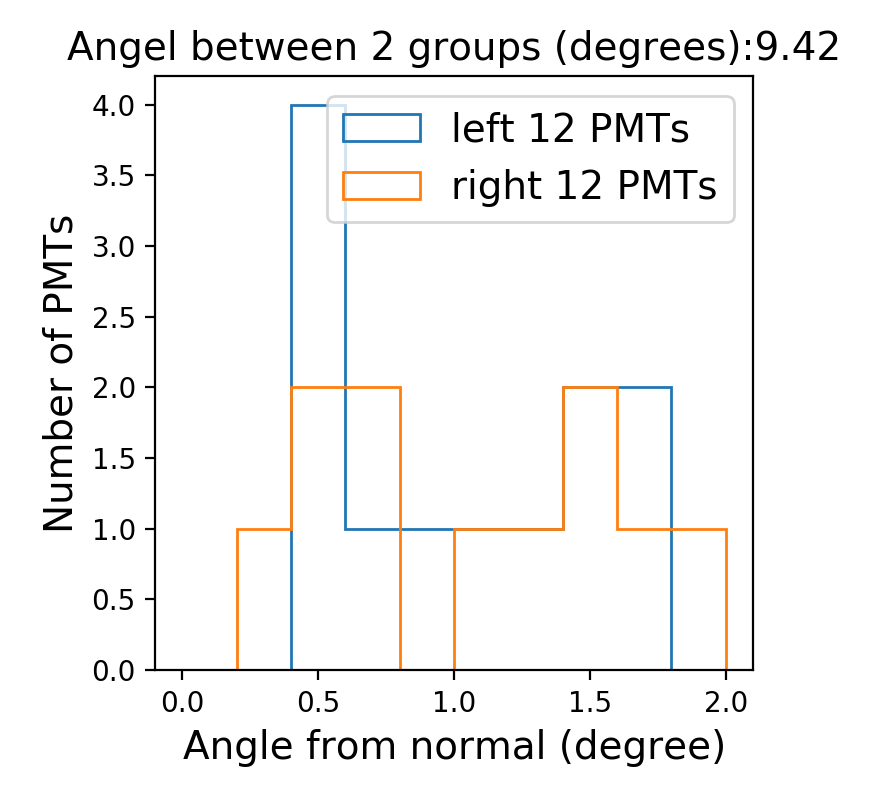

In [66]:
plt.figure(figsize=(4,4))
ax = plt.subplot(111)
ax.hist(theta1, histtype='step', bins=10, range=(0,2),label='left 12 PMTs')
ax.hist(theta2, histtype='step', bins=10, range=(0,2),label='right 12 PMTs')
ax.set_xlabel('Angle from normal (degree)', fontsize=14)
ax.set_title('Angel between 2 groups (degrees):%.2f'%(diff_2walls), fontsize=14)
ax.legend( fontsize=14)
ax.set_ylabel('Number of PMTs', fontsize=14)
plt.tight_layout()